In [1]:
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U git+https://github.com/huggingface/trl
!pip install -q xformers wandb datasets einops gradio sentencepiece bitsandbytes
!pip install -q "huggingface_hub[cli]"


In [3]:
!pip install -Uq flash-attn

In [4]:
!nvidia-smi

Sat Jan 18 21:34:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:08:00.0 Off |                  Off |
| 30%   41C    P0             37W /  300W |       2MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


# Importing necessery libraries

---

In [6]:
import os

os.environ['WANDB_MODE'] = 'disabled'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.4"
import torch
import wandb
import platform
import warnings
import transformers
from datetime import datetime
from datasets import Dataset

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, HfArgumentParser, TrainingArguments,  logging, TextStreamer
from transformers import AutoModel
from peft import LoraConfig, PeftModel, LoftQConfig,  prepare_model_for_kbit_training, get_peft_model
from datasets import load_dataset
from trl import SFTTrainer, DPOTrainer, KTOConfig, KTOTrainer, SFTConfig
import pandas as pd

secret_value_0 = "Ha ha, got them"

In [7]:
!huggingface-cli login --token $secret_value_0

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `kaggle` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `kaggle`


# Reading the dataset

---

In [55]:
train_df = pd.read_json("/space/zno.train.jsonl", lines=True)
test_df = pd.read_json("/space/zno.test.jsonl", lines=True)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_eval_split = train_dataset.train_test_split(test_size=0.3, seed=42)

train_split = train_eval_split['train']
eval_split = train_eval_split['test']

print(f"Train size: {len(train_split)}, Eval size: {len(eval_split)}")

Train size: 2144, Eval size: 919


In [9]:
# utility function to test output
def stream(model, tokenizer, user_input, instruction, template, max_new_tokens=125, generation_params={}):
    runtimeFlag = "cuda:0"
    system_prompt = ''
    
    prompt = template.format(instruction=instruction, user_input=user_input)
    print("Input:", prompt)
    print("Output:")

    inputs = tokenizer(prompt, return_tensors="pt").to(runtimeFlag)
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    _ = model.generate(**inputs, streamer=streamer, max_new_tokens=max_new_tokens, **generation_params)


In [18]:
# model_id = "Qwen/Qwen2.5-3B-Instruct"
# model_id = "meta-llama/Llama-2-7b-chat-hf"
# model_id = "Qwen/Qwen2.5-3B-Instruct-GGUF"
# model_id = "unsloth/Qwen2.5-3B-Instruct-bnb-4bit" - already quantized, not need BitsAndBiases
model_id = "unsloth/Qwen2.5-32B-bnb-4bit" 
# model_id = "yuriivoievidka/qwen-32B-qlora-ukr-medalist"

## Quantization using Bites and Bytes

---

In [19]:
# already quantized
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_use_double_quant=True,
# )

## Loading pretrained

---

Unfortynatelly Flash Attention is Not supported on P100

In [12]:
# Load model and setup quantization
use_flash_attn = True 

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    # quantization_config=bnb_config,
    device_map={"": 0},
    trust_remote_code=True,
    attn_implementation="flash_attention_2" if use_flash_attn else "eager"
)

# model = prepare_model_for_kbit_training(model)
model.config.use_cache = False
model.config.pretraining_tp = 1
# model = model.to("cuda")

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


model-00001-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/4.32G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
model

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(152064, 5120)
        (layers): ModuleList(
          (0-63): 64 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [30]:
model.enable_input_require_grads() 
model.dtype

torch.float16

## Define the tokenizer for the model

---

In [31]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.bos_token_id = 1
model.generation_config.pad_token_id = tokenizer.pad_token_id


## EDA of training data
---

In [32]:
train_dataset[0]

{'question': 'Позначте рядок, у якому в усіх словах потрібно писати літеру *и*:',
 'answers': [{'marker': 'А',
   'text': 'бад..лина, благоч..стивий, кр..хкий, ж..виця;'},
  {'marker': 'Б', 'text': 'вар..во, меж..річчя, вич..пурений, кр..шталь;'},
  {'marker': 'В', 'text': 'п’ят..річка, заруч..ни, нев..димка, обітн..ця;'},
  {'marker': 'Г', 'text': 'зач..нати, виконав..ця, знів..чити, вел..чина;'},
  {'marker': 'Д', 'text': 'нож..чок, печ..во, викор..нити, оз..ратися.'}],
 'correct_answers': ['В'],
 'subject': 'ukrainian-language-and-literature',
 'text': "<|im_start|>system\\Ви асистент що допомагає відповідати на тести українською мовою. Завжди позначайте правильну відповідь у форматі: [А], [Б], [В], [Г] або [Д]. Пиши лише відповідь, нічого окрім неї<|im_end|>\n<|im_start|>user\nПозначте рядок, у якому в усіх словах потрібно писати літеру *и*:\n[{'marker': 'А', 'text': 'бад..лина, благоч..стивий, кр..хкий, ж..виця;'}, {'marker': 'Б', 'text': 'вар..во, меж..річчя, вич..пурений, кр..шт

In [17]:
train_dataset.features

{'question': Value(dtype='string', id=None),
 'answers': [{'marker': Value(dtype='string', id=None),
   'text': Value(dtype='string', id=None)}],
 'correct_answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'subject': Value(dtype='string', id=None)}

## Prepare train data with QWEN specific prompt

---

In [ ]:
QWEN_TRAIN_TEMPLATE = (
    "<|im_start|>system\Ви асистент що допомагає відповідати на тести українською мовою. Завжди позначайте правильну відповідь у форматі: [А], [Б], [В], [Г] або [Д]. Пиши лише відповідь, нічого окрім неї<|im_end|>\n"
    "<|im_start|>user\n{question}\n{answers}<|im_end|>\n"
    "<|im_start|>assistant\n{correct_answers}<|im_end|>\n"
)

def generate_prompt(record):
    # Format the prompt using the QWEN_TRAIN_TEMPLATE
    prompt = QWEN_TRAIN_TEMPLATE.format(
        question=record['question'], 
        answers=record['answers'],
        correct_answers=record['correct_answers']
    )
    return {'text': prompt}

# Apply the QWEN template to the train dataset
train_split = train_split.map(generate_prompt)
train_split[0]


## Prepare test data with QWEN specific prompt

---

In [58]:
# The same for the eval split
eval_split = eval_split.map(generate_prompt)
eval_split[0]

Map:   0%|          | 0/919 [00:00<?, ? examples/s]

{'question': '**Прочитайте текст і виконайте завдання**\n\n\n(1) Тисячі дітей, *не/збайдужілих* до літератури, знають Івана Малковича – доброго дядечка-казкаря. (2) Після закінчення університету, незважаючи на різноманітні **пропозиції**, юнак, ще *не/відомий* нікому, починає вчителювати в сільській школі під Києвом. (3) Хто міг уявити тоді, що саме цей хлопець стане […] найкращого в Україні дитячого **видавництва** і, якщо треба буде, не залишатиме **друкарні** по дві доби? (4) Створені тут **книги** «Снігова королева», «Абетка», «Аліса\xa0в Дивокраї», «Тореадори з Васюківки», «Вінні-Пух» – справжні *не/перевершені* ніким витвори поліграфічного мистецтва. (5) В одному з *не/давніх* рейтингів «50 найкращих сучасних поетів» його прізвище посідає п’яте місце. (6) Вражає й такий рекорд: «А-БА-БА-ГА-ЛА-МА-ГА» за двадцять років випустила понад п’ять мільйонів книжок.\n\n\nЗамість пропуску в третьому реченні можуть бути всі слова, ОКРІМ',
 'answers': [{'marker': 'А', 'text': 'засновником'},


## LoRa parameters' investigation


*Low-Rank Adaptation (LoRA) is a PEFT method that decomposes a large matrix into two smaller low-rank matrices in the attention layers. This drastically reduces the number of parameters that need to be fine-tuned.*


        
- task_type: the task to train for (sequence-to-sequence language modeling in this case)

- inference_mode: whether you’re using the model for inference or not

- r: the dimension of the low-rank matrices

- lora_alpha: the scaling factor for the low-rank matrices

LoRA introduces low-rank matrices to approximate the weight updates in a model, keeping the pre-trained weights frozen.
The updates from the low-rank matrices are scaled by lora_alpha before being applied.
Balancing Stability and Learning:

A higher lora_alpha amplifies the updates, potentially allowing the model to learn faster but risking instability or overfitting.
A lower lora_alpha makes the updates smaller, leading to more stable training but potentially slower convergence.


- lora_dropout: the dropout probability of the LoRA layers

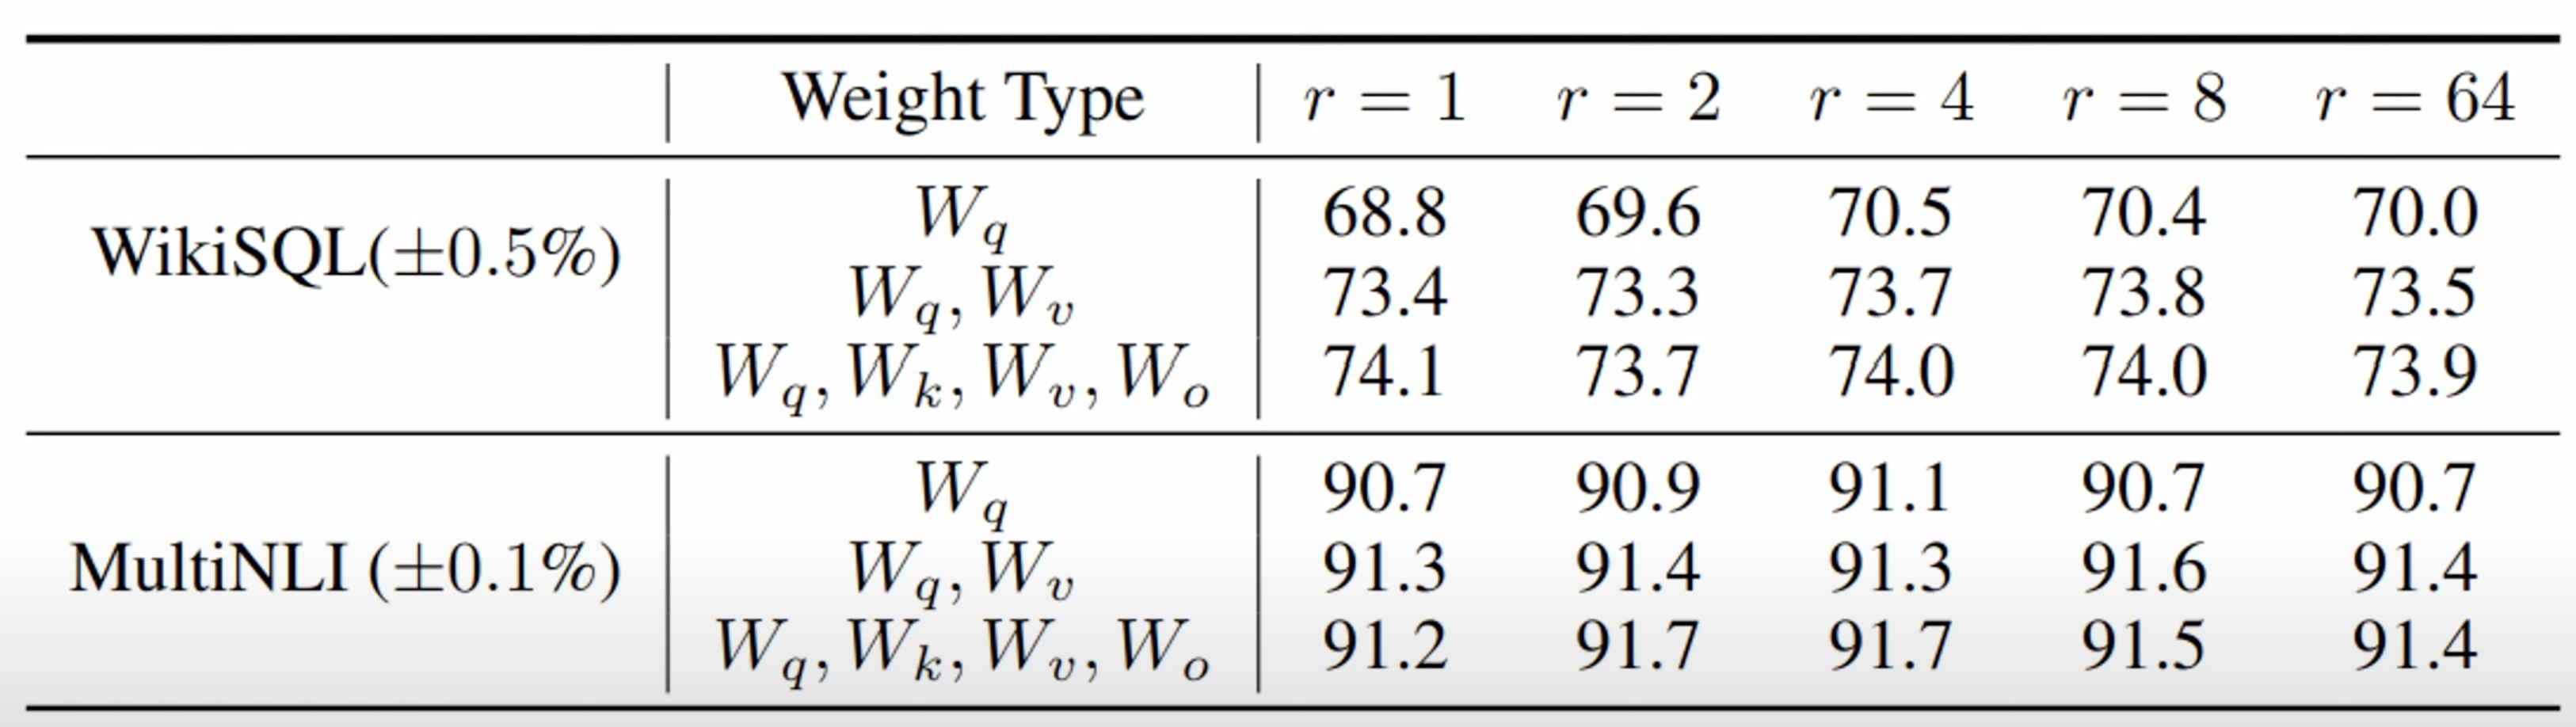
paper says that very small LoRa doesn't decrease performance much, so well, let it be 16

In [23]:
peft_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.1,
    r=16,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
    # target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj"],
    # target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    target_modules="all-linear"
)

In [24]:
from peft import get_peft_model

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 134,217,728 || all params: 32,898,094,080 || trainable%: 0.4080


## Training

---

In [70]:
output_dir = "./results"
run_name = "testrun"

training_arguments = SFTConfig(
    dataset_text_field="text",
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    optim="paged_adamw_8bit",
    save_steps=200,
    save_strategy="steps",  # Replace with "eval_strategy" if required
    eval_steps=200,
    eval_strategy="steps",  # Updated
    do_eval=True,
    logging_steps=20,
    warmup_ratio=0.1,
    learning_rate=2.5e-4,
    lr_scheduler_type="linear",
    logging_dir="./logs",
    report_to="wandb",
    max_seq_length=256,
    run_name=f"{run_name}-(datetime.now().strftime('%Y-%m-%d-%H-%M'))"
)

tokenizer.padding_side = "right"

trainer = SFTTrainer(
    model=model,
    train_dataset=train_split,
    eval_dataset=eval_split,
    peft_config=peft_config,
    processing_class=tokenizer,  # Updated from tokenizer
    args=training_arguments
)

Map:   0%|          | 0/2144 [00:00<?, ? examples/s]

Map:   0%|          | 0/919 [00:00<?, ? examples/s]

In [71]:
import gc
torch.cuda.empty_cache()
gc.collect()

4288

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


## Pushing model to my hugging face repo to not loose it

---


In [ ]:
ft_model_id = "qwen-32B-qlora-ukr-golden-medalist"

trainer.save_model(ft_model_id)
model.save_pretrained(ft_model_id, safe_serialization=False)

In [68]:
model.push_to_hub(ft_model_id)
tokenizer.push_to_hub(ft_model_id)

adapter_model.safetensors:   0%|          | 0.00/537M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yuriivoievidka/qwen-32B-qlora-ukr-golden-medalist/commit/102759b73811025d01924a4546b2e9545f973e7d', commit_message='Upload tokenizer', commit_description='', oid='102759b73811025d01924a4546b2e9545f973e7d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yuriivoievidka/qwen-32B-qlora-ukr-golden-medalist', endpoint='https://huggingface.co', repo_type='model', repo_id='yuriivoievidka/qwen-32B-qlora-ukr-golden-medalist'), pr_revision=None, pr_num=None)

## Model Testing and generating submission

---

In [69]:
QWEN_TEMPLATE = (
    "<|im_start|>system\Ви асистент що допомагає відповідати на тести українською мовою. Завжди позначайте правильну відповідь у форматі: [А], [Б], [В], [Г] або [Д]. Пиши лише відповідь, нічого окрім неї<|im_end|>\n"
    "<|im_start|>user\n{question}\n{answers}<|im_end|>\n"
    "<|im_start|>assistant\n"
)

def generate_answers(record):
    prompt = QWEN_TEMPLATE.format(
        question=record['question'], 
        answers=record['answers']
    )
    
    tokenized_prompt = tokenizer(prompt, return_tensors="pt")
    
    device = model.device
    input_ids = tokenized_prompt['input_ids'].to(device)
    attention_mask = tokenized_prompt.get('attention_mask', None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)
    
    generated = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=20,
        temperature=0.02
    )

    answer = tokenizer.decode(generated[0], skip_special_tokens=True).strip()
    return {'predicted_answer': answer}

test_dataset = test_dataset.map(generate_answers)
df = test_dataset.to_pandas()
df[['id', 'predicted_answer']].to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

Map:   0%|          | 0/751 [00:00<?, ? examples/s]

/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:626: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.02` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Submission file 'submission.csv' created successfully.


## Another round of testing

just checking how it generated


---

In [35]:
# Limit the dataset to the first 2 records
test_dataset_subset = test_dataset.select(range(2))

test_dataset_subset = test_dataset_subset.map(generate_answers)

df = test_dataset_subset.to_pandas()
df[['id', 'predicted_answer']].to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully with the first 10 records.")


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:626: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Submission file 'submission.csv' created successfully with the first 10 records.


In [39]:
df.head()['predicted_answer'][1]

'system\\Ви допомагаєте відповідати на тести українською мовою. Завжди позначайте правильну відповідь у форматі [А], [Б], [В], [Г] або [Д] \nuser\nУдовин син, мати, сестра, кохана – ключові образи твору\n[{\'marker\': \'А\', \'text\': \'«Засвіт встали козаченьки»\'}, {\'marker\': \'Б\', \'text\': \'«Ой Морозе, Морозенку»\'}, {\'marker\': \'В\', \'text\': \'«Дума про Марусю Богуславку»\'}, {\'marker\': \'Г\', \'text\': \'«Чи не той то хміль»\'}, {\'marker\': \'Д\', \'text\': \'«Ой летіла стріла»\'}]\nassistant\n[В] "Дума про Марусю Богуславку" - це по'

## And another model testing

---

In [42]:
CUSTOM_TEMPLATE = """<s>[INST] <<SYS>>\n{instruction}\n<</SYS>>\n\n{user_input} [/INST]"""

stream(
    model, tokenizer,
    user_input="Хто такий Карлсон: Хто такий Карлсон (придуманий Астрід Ліндгрен)?",
    instruction="Відповісти на питання:",
    template=CUSTOM_TEMPLATE,
    max_new_tokens=5,
    generation_params={'temperature': 0.001}
)


/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:626: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Input: <s>[INST] <<SYS>>
Відповісти на питання:
<</SYS>>

Хто такий Карлсон: Хто такий Карлсон (придуманий Астрід Ліндгрен)? [/INST]
Output:
 Карлсон - ц
